## Otorowiri

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

modules = utils.list_modules(loopflopy)
#for module in modules: print(module)

os.getcwd()

'c:\\Users\\00105010\\Projects\\Otorowiri\\scripts'

### 1. Setup Project

In [3]:
name = 'otorowiri'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe)
project.crs = 28350  # UTM zone 50S, EPSG:28350

project.mfexe

'../exe/mf6.exe'

### 2. DEM

In [4]:
# A bounding box for structural model
x0, x1 = 320000, 400000
y0, y1 = 6670000, 6780000
z0, z1 = -1500, 400
bbox = [(x0, y0, z0), (x1, y1, z1)]

from loopflopy.spatial_routines import make_bbox_shp
crop_polygon = make_bbox_shp(x0, x1, y0, y1, crs=project.crs, fname = '../data/data_shp/structuralmodel.shp')

-9999.0


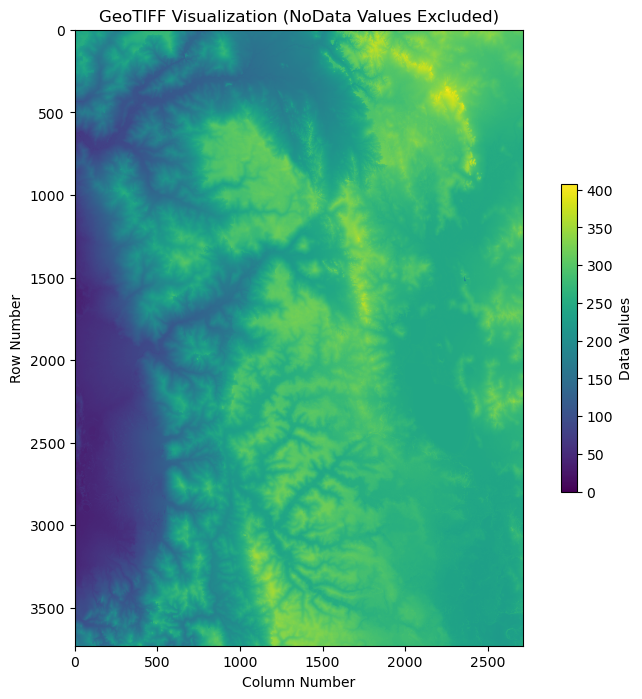

No special cells


In [5]:
import process_dem
#process_dem.model_DEM(crop_polygon) #only need to do once!

from loopflopy.dem import DEM
geotiff_fname = '../Data/data_dem/Otorowiri_Model_DEM.tif'
dem = DEM(geotiff_fname = geotiff_fname)
dem.plot_geotiff()

# RESAMPLE TOPO 
from loopflopy.mesh_routines import create_structured_mesh
mesh = create_structured_mesh(bbox, ncol = 100, nrow = 100)
#dem.resample_topo(project, mesh, crop_polygon, fname = '../modelfiles/structuralmodel_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes

# LOAD TOPO
#dem.load_topo(project, fname = '../modelfiles/structuralmodel_topo.pkl')
#dem.plot_topo(mesh, levels = [0, 100, 200, 300, 400, 500, 600, 700])

### 3. Structural Model

In [21]:
geodata_fname = '../data/data_geology/bore_data_Otorowiri.xlsx'
data_sheetname = 'geodata_elevation'
strat_sheetname = 'strat'
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(bbox, geodata_fname, data_sheetname, strat_sheetname) #spatial and bbox come from the spatial module, excel file and sheet names are user defined

In [22]:
import process_structural

process_structural.geo_boundaries(project, structuralmodel, crop_polygon, simplify_tolerance =1000, node_spacing = 2000)
process_structural.prepare_strat_column(structuralmodel)
process_structural.add_geo_boundaries(structuralmodel)
process_structural.elevation_fill(structuralmodel)
process_structural.prepare_geodata(structuralmodel)
process_structural.create_structuralmodel(structuralmodel)
structuralmodel.model.to_file('../modelfiles/structuralmodel') #pickle the model to send to people
structuralmodel.data.to_excel('../modelfiles/structuraldata.xlsx', index=False) # Check the data used for structural model
structuralmodel.strat.to_excel('../modelfiles/structuralstrat.xlsx', index=False) # Check the stratigraphy used for structural model

     sequence    unit    R    G    B   val  lithid Thickness  iconvert    hk  \
0      Ground  Ground  255  255  255     0      -1         -       NaN   NaN   
1  Yarragadee      Kp  172  186  242   124       0      -124       1.0  10.0   
2  Yarragadee     Kpo  117  128  229   100       1        24       0.0   0.1   
3  Yarragadee      Jy  198  217  240 -1000       2      1100       0.0  10.0   

     vk       ss    sy  
0   NaN      NaN   NaN  
1  10.0  0.00001  0.10  
2   0.1  0.00001  0.01  
3  10.0  0.00001  0.20  

Updated DataFrame with geo_boundaries written to new sheet: 'geo_boundaries' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
DEM bounds:
  xmin (left):   319999.2808458023
  ymin (bottom): 6669986.956668399
  xmax (right):  400000.3649361293
  ymax (top):    6780029.0232758615
  CRS:           EPSG:28350
DataFrame coordinate extents:
  Easting:  min = 333143.0, max = 375240.0
  Northing: min = 6676044.2014097, max = 6769139.992891274
Filled 112 missing 'Ground_m


Updated DataFrame written to new sheet: 'structuralmodel_data' in file: ../data/data_geology/bore_data_Otorowiri.xlsx
1.6.13


c:\Users\00105010\Anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


['Ground', 'Yarragadee']


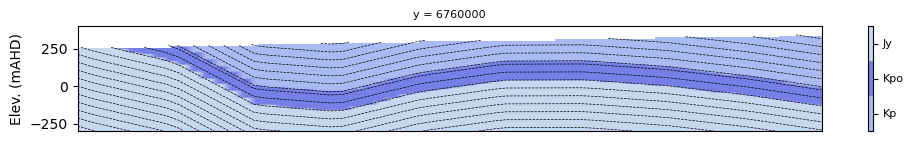

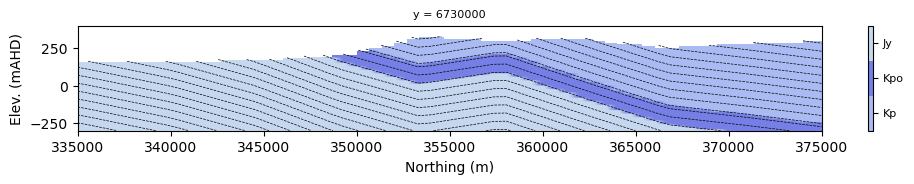

['Ground', 'Yarragadee']


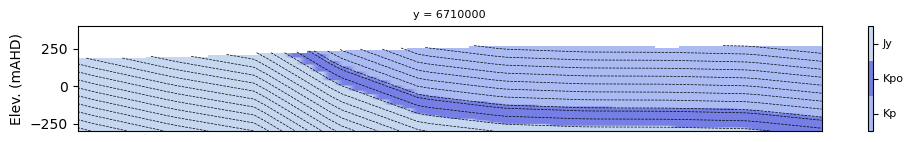

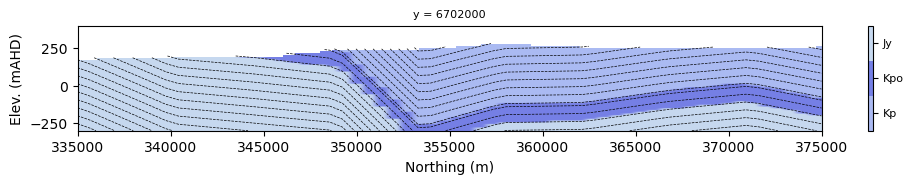

In [23]:
z0 = -300 # just for plotting. Make sure within bbox of structural model
z1 = 300   # just for plotting. Make sure within bbox of structural model
nh, nz = 90, 90 # plotting resolution

#import pyvista
#from LoopStructural.visualisation import Loop3DView
#view = Loop3DView(structuralmodel.model)
#view.plot_model_surfaces()
#view.plot_data(structuralmodel.model['Yarragadee'])
#view.set_scale(zscale = 10)
#view.show()

transect_x = [375000]#, 400000, 410000]
# DONGARA LINE - 6750000
# ENEABBA LINE - 6700000
transect_y = [6760000, 6730000]# 6700000]
#structuralmodel.plot_xtransects(transect_x, ny = 80, nz = 120)#, x1 = 6520000, z0 = -2000) 
#structuralmodel.plot_ytransects(transect_y, nx = 80, nz = 120, z0 = -1000) 
structuralmodel.plot_ytransects2(transect_y, nx = 60, nz = 60, dz = 10, x0 = 335000, x1 = 375000, z0 = -300, z1 = 400) #x0 = 335000, x1 = 352000, z0 = -200, z1 = 300

transect_y = [6710000, 6702000]
structuralmodel.plot_ytransects2(transect_y, nx = 60, nz = 60, dz = 10, x0 = 335000, x1 = 375000, z0 = -300, z1 = 400) #x0 = 335000, x1 = 352000, z0 = -200, z1 = 300


In [24]:
#for i in range(len(spatial.xsections)):
#    start = spatial.xsections[i][0]
#    end   = spatial.xsections[i][1]

#    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0-1000, z1 = z1+1000, nh = nh, nz = nz)

#structuralmodel.contour_bottom(spatial, contour_interval = 10) #unit = 'Kp', 

### 4. Surface Refinement

Max ground level =  311.0
Min ground level =  169.0
No special cells
number of cells in plan =  40000
   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  6.642878
   1. Evaluating structural model...
len(xyz) =  5840000
Time taken Block 1 (Evaluate model) =  29.238076
   2. Creating geo model layers...
stop_array shape (4, 40000)
nlay =  146
ncpl =  40000
nlg number of geo layers =  3
Time taken Block 2 create geomodel layers  1.120605
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.001
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.080018
   5. Calculating gradients...
Time taken Block 5 gradients=  3.048269


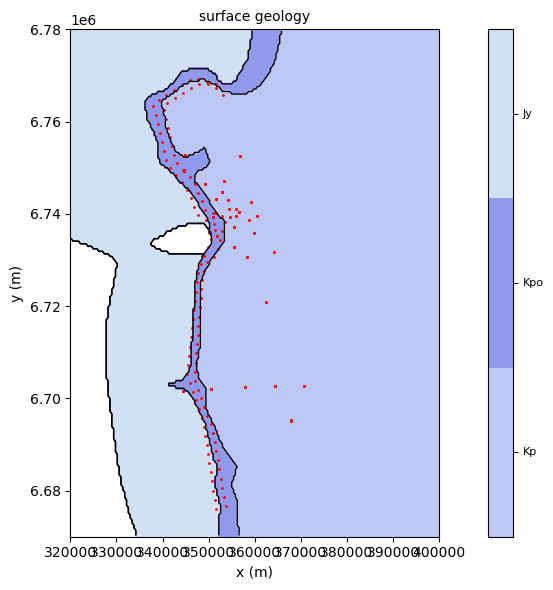

c:\users\00105010\projects\loopflopy\loopflopy\surfacerefinement.py:120: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [25]:
from loopflopy.surfacerefinement import SurfaceRefinement
surfacerefinement = SurfaceRefinement(structuralmodel, nrow = 200, ncol = 200)
surfacerefinement.create_surf_lith_raster(structuralmodel)
surfacerefinement.surface_contours(project, structuralmodel, plot_datapoints = True)

### 5. Model boundary

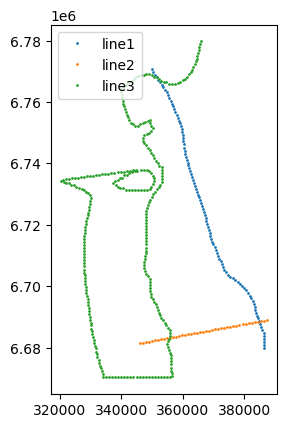

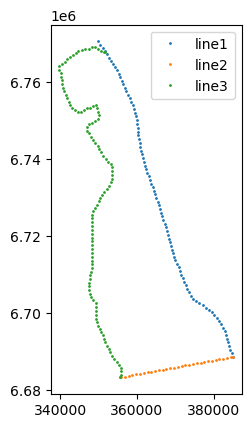

NameError: name 'trimmed_lines' is not defined

In [ ]:
import process_boundary
raw_lines, labels = process_boundary.gather_boundary_linestrings(project)
process_boundary.plot_linestrings(raw_lines, labels)
trimmed_lines = process_boundary.trim_boundary_linestrings(raw_lines)
process_boundary.plot_linestrings(trimmed_lines, labels)
snapped_lines = process_boundary.snap_linestring_endpoints(trimmed_lines, tolerance=1000)  # 5 units tolerance, adjust as needed
model_boundary_poly = process_boundary.make_boundary_polygon(trimmed_lines, snapped_lines)

### 6. Spatial

In [11]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = project.crs)

import process_spatial
process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 0, node_spacing = 2000)
process_spatial.geo_bores(spatial)
process_spatial.obs_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.arrow(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.rivers(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)
#process_spatial.outcrop(spatial, node_spacing = 200, buffer_distance = 200, threshold = 100)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(340000, 6690000),(385000, 6700000)], 
                     [(340000, 6730000),(365000, 6740000)],
                     [(345000, 6780000),(370000, 6680000)]
                     ]

#extent = [[330000, 370000],[6740000, 6770000]] #[[342000, 370000],[6725000, 6745000]] # extent[[x0,x1], [y0,y1]]
extent = [[330000, 370000],[6680000, 6770000]]
process_spatial.plot_spatial(spatial, structuralmodel,
                 labels = False, # Bore ids
                 obsbores = False, 
                 pumpbores = False, 
                 geobores = True, 
                 rivers = False, # thre three river
                 arrow = True, # Just arrowsmith
                 structuralmodel_data = True,
                 xsections = True,
                 #extent = extent # Just hash out to see the whole model
                 ) 

DataSourceError: ../modelfiles/model_boundary_polygon.shp: No such file or directory

In [12]:
m = spatial.obsbore_gdf.explore()#location=[-31.4, 115.8], zoom_start=11, popup = 'ID')
#m = folium.Map(location=[52.0, 4.0], zoom_start=6) 
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')

### 3. Mesh

arrow_nodes
number of cells in plan =  4389


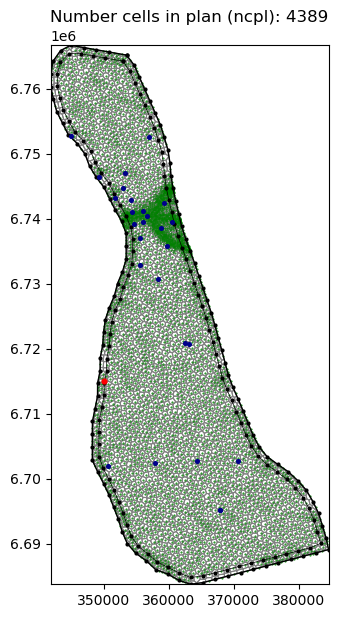

In [13]:
from loopflopy.mesh import Mesh
# groups: obs, wel, chd, ghb, poly 
special_cells = {
                 #'rivers': ['arrow'],
                 #'wel': ['pumpbores'], 
                 'obs': ['obsbores'],
                 'poly': ['arrow']
                 }
mesh = Mesh(plangrid = 'vor', special_cells = special_cells) # special cells to identify as arguements

mesh.modelmaxtri = 400000 # was 400000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 200 # radius of inner circle around pumping bores
mesh.radius2 = 600 # radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['arrow_nodes']#'bore_refinement_nodes']
polygon_list = ['model_boundary_poly', 'inner_boundary_poly', ]

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

xlim = extent[0]
ylim = extent[1]
features = ['wel', 'obs', 'arrow']
mesh.plot_cell2d(spatial, features, xlim = None, ylim = None, nodes = False, labels = False) # Just exclude xlim, ylim if plotting whole thing

### 4. Find Cell IDs of spatial features

Group =  obs ['obsbores']
flag = 1
Group =  poly ['arrow']
flag = 2
poly_arrow_cells
[0 1 2]
[0 1 2]


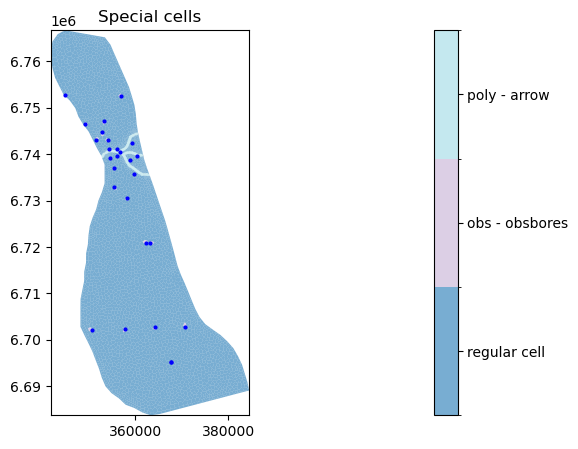

In [14]:
mesh.locate_special_cells(spatial)
mesh.plot_feature_cells(spatial) #, xlim, ylim)

### 6. Geomodel

In [15]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -300, 300 

from loopflopy.geomodel2 import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 4, res = 1, nlg = 1) # include nlg if you only want some of the top geo layers included in flow model
geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  1.972424

   1. Evaluating structural model...
len(xyz) =  2633400
Time taken Block 1 (Evaluate model) =  12.762127

   2. Creating geo model layers...
ncpl =  4389
nlg number of geo layers =  1
top_geo shape (4389,)
botm_geo (1, 4389)
Time taken Block 2 create geomodel layers  0.406113

   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.0

   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.004001

   5. Calculating gradients...
Time taken Block 5 gradients=  0.329166


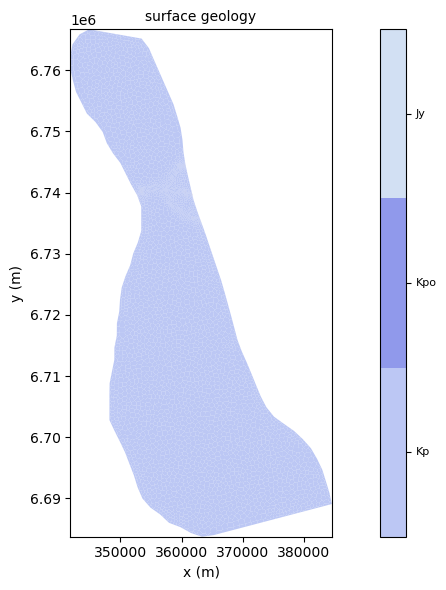

c:\users\00105295\projects\loopflopy\loopflopy\geomodel2.py:619: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


In [16]:
# Surface lithology
geomodel.get_surface_lith()
geomodel.geomodel_plan_lith(spatial, mesh, structuralmodel)

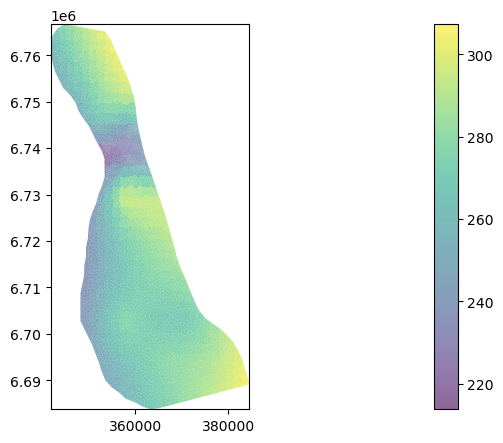

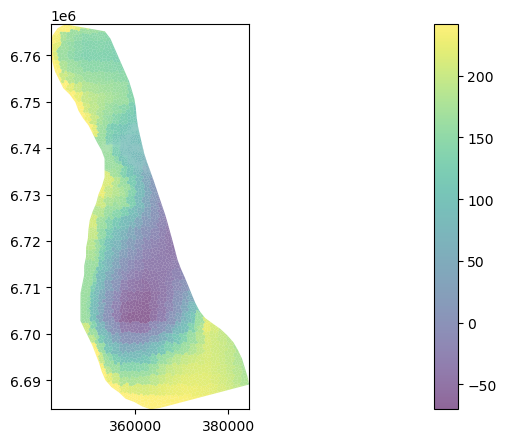

In [17]:
# Geomodel top, bottom of layer 0
geomodel.plot_surface(geomodel.top_geo)
geomodel.plot_surface(geomodel.botm_geo[0])

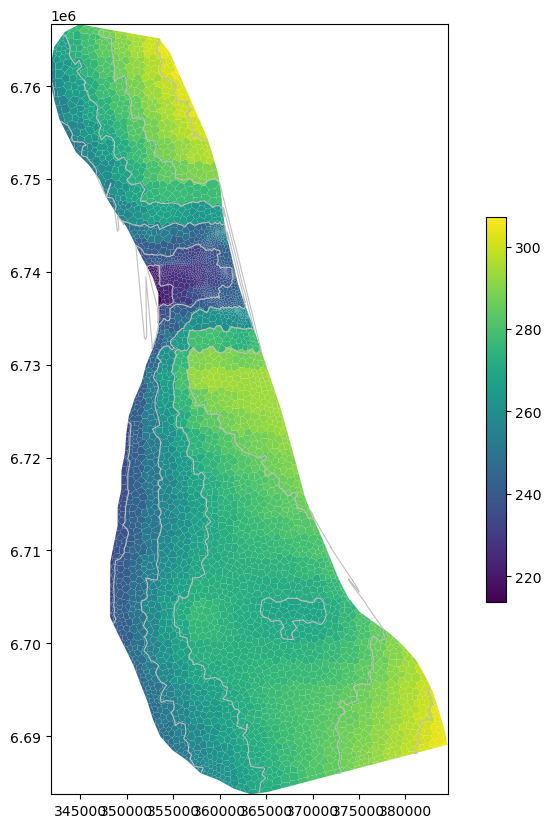

In [18]:
# Different way of plotting top
array = geomodel.top_geo
mesh.plot_surface_array(array, structuralmodel)

In [ ]:
# RESAMPLE TOPO 
dem.resample_topo(project, mesh, crop_polygon, fname = '../modelfiles/geomodel_topo.pkl') # only need to run when mesh changes. Take 1-2 minutes
dem.load_topo(project, fname = '../modelfiles/geomodel_topo.pkl')
dem.plot_topo(mesh, levels = [0, 100, 200, 300, 400, 500, 600, 700])

None
EPSG:28350


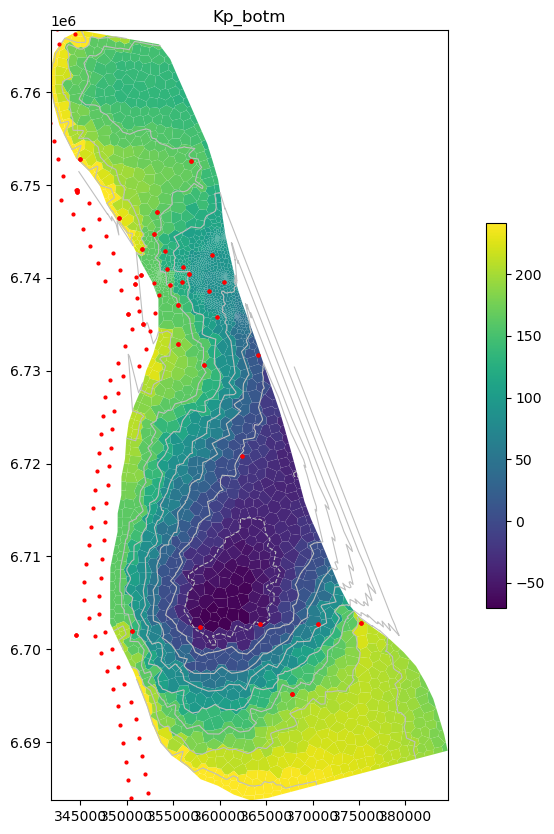

In [ ]:
# Bottom of Parmelia
array = geomodel.botm_geo[0] # Botm Kp
title = 'Kp_botm'
mesh.plot_surface_array(array, structuralmodel, title = title, plot_data = True, lithcode = 'Kp')

Kp has  0  negative thickness values
Kp has min geo thickness of  1.334977149963379  m


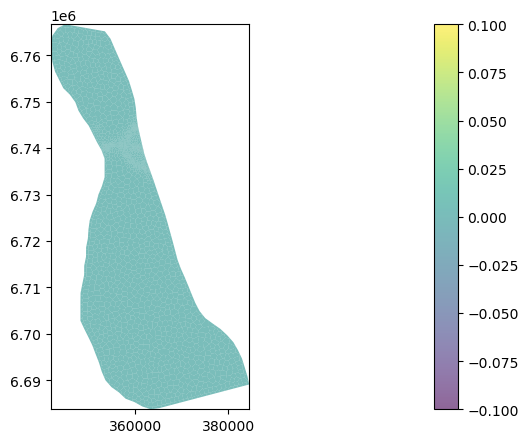

In [ ]:
# Parmelia thickness
Kp_thick = geomodel.top_geo - geomodel.botm_geo[0] #dem.topo - geomodel.botm_geo[0]
print('Kp has ', np.sum(Kp_thick < 0), ' negative thickness values')
print('Kp has min geo thickness of ', np.min(Kp_thick), ' m')
geomodel.plot_surface(Kp_thick <= 0) # Yellow plots negative or zero thickness

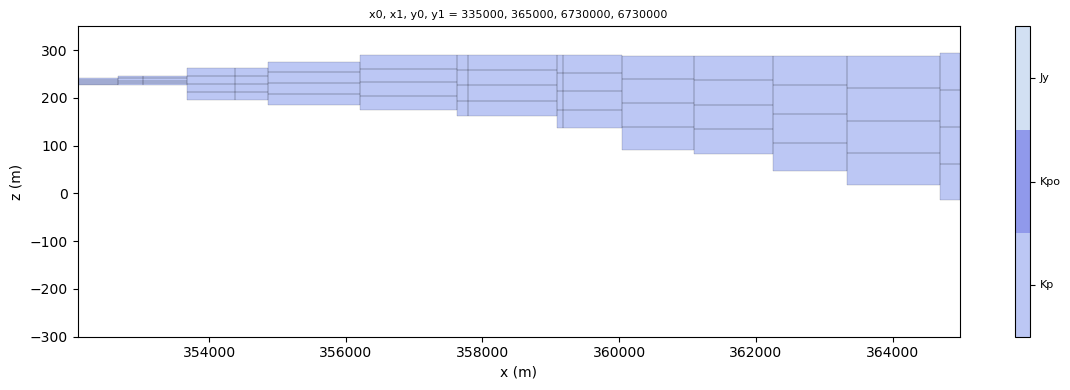

In [ ]:
# Geomodel transect
y0, y1 = 6730000, 6730000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1, x0 = 335000, x1 = 365000, z0 = -300, z1 = 350)# z0 = -200, z1 = 300


### 7. Assign hydrogeological parameters to cells

In [ ]:
# FILL CELL PROPERTIES
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'strat')
props = props.drop(index=[0]).reset_index()#inplace=True) # drop first row as it is ground
geomodel.hk_perlay = props.hk.tolist()
geomodel.vk_perlay = props.vk.tolist()
geomodel.ss_perlay = props.ss.tolist()
geomodel.sy_perlay = props.sy.tolist()
geomodel.iconvert_perlay = props.iconvert.tolist()
geomodel.fill_cell_properties(mesh)
props

   6. Filling cell properties...
ang1 shape  (4, 4389)
17556
angle1 shape  (17556,)
Time taken Block 6 Fill cell properties =  0.002


,index,sequence,unit,R,G,B,val,lithid,Thickness,iconvert,hk,vk,ss,sy
0,1,Yarragadee,Kp,172,186,242,124,0,NaN,1.0,10.0,10.0,0.00001,0.10
1,2,Yarragadee,Kpo,117,128,229,100,1,NaN,0.0,0.1,0.1,0.00001,0.01
2,3,Yarragadee,Jy,198,217,240,-1000,2,NaN,0.0,10.0,10.0,0.00001,0.20


In [ ]:
geomodel.k11

array([10., 10., 10., ..., 10., 10., 10.])

### 8. Prepare Data for Flowmodel

In [ ]:
from process_data import *
data = Data()

# INITIAL CONDITIONS
data.process_ic()

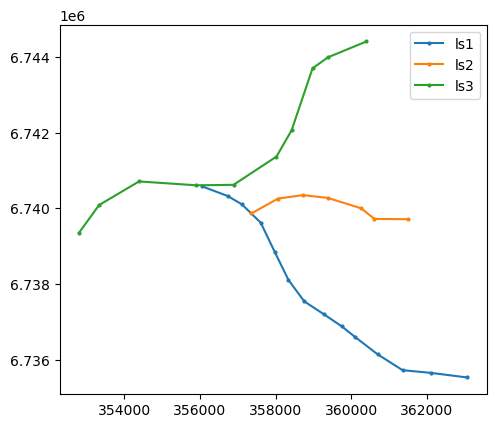

Number of drain cells =  123


In [ ]:
# DRAIN
drain_linestrings = data.process_drn_linestrings(spatial)
drn_ibd, drn_cellids, drn_lengths = data.get_drain_cells(drain_linestrings, geomodel)
data.make_drain_rec(geomodel, drn_cellids, drn_lengths)

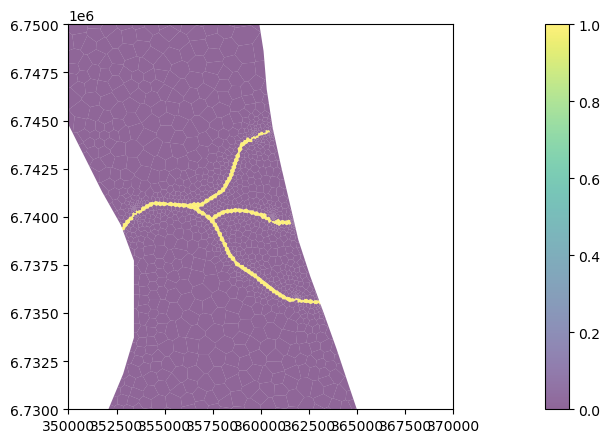

In [ ]:
geomodel.plot_surface(drn_ibd, xlim = [350000, 370000], ylim = [6730000, 6750000]) # z0 = -200, z1 = 300

In [ ]:
data.process_rch(geomodel)
data.process_evta(geomodel)

### 9. Groundwater observations

In [ ]:
# First sorting out observation bores
import process_observations
#from process_observations import plot_hydrograph
df_boreids = process_observations.prefilter_data()
df_boredetails = process_observations.assemble_clean_data(df_boreids)
#creare all the hydrographs for the narrowed down bore ids
#process_observations.plot_hydrograph(df_boredetails, spatial)

Unique Parmelia bore IDs: ['Pugh 3' 'El1C' 'El2B' 'El3B' 'El3C' 'El4A' 'WNR1C' 'WNR2A' 'WNR2B'
 'WNR2C' 'WNR2D' 'WNR3A' 'WNR3B' 'WNR3C' 'AR1' 'AR6(ART)' 'AR7' 'AR9'
 'AR10(ART)' 'AR11' 'AR12(ART)' 'AR13' 'AR14' 'AR15' 'AR16' 'AR17' 'AR18'
 'AR20' 'AR21' 'AR22' 'AR23' 'AR26' 'AR27' 'AR8' 'AR19' 'No.2' 'DL5W']
Bore detail columns are: Index(['Site Ref', 'Aquifer Name', 'Site Short Name', 'Easting', 'Northing',
       'From (mbGL)', 'To (mbGL)', 'Inside Dia. (mm)', 'GL source', 'GL mAHD',
       'Measurement Point Type', 'Screen top', 'Screen bot', 'zobs'],
      dtype='object')


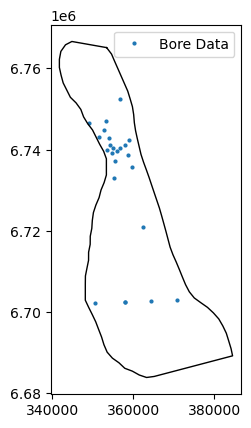

In [ ]:
df = pd.read_csv('../data/data_waterlevels/obs/cleaned_obs_bores_KB.csv')
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Easting, df.Northing), crs=project.crs)
spatial.model_boundary_poly

fig, ax = plt.subplots() 
ax.plot(gdf.geometry.x, gdf.geometry.y, 'o', ms = 2, label = 'Bore Data')  # You can set color, linestyle, etc.
x, y = spatial.model_boundary_poly.exterior.xy
ax.plot(x, y, '-', ms = 2, lw = 1, color='black')

ax.set_aspect('equal')
ax.legend()
plt.show()

In [ ]:
df = pd.read_csv('../data/data_waterlevels/obs/cleaned_obs_bores_KB.csv')
df

,Site Ref,Aquifer Name,id,Easting,Northing,From (mbGL),To (mbGL),Inside Dia. (mm),GL source,GL mAHD,Screen top,Screen bot,zobs
0,70112636,Perth-Parmelia,AR1,356650.04,6740425.49,NaN,NaN,NaN,Ground level,208.570,NaN,NaN,NaN
1,70118004,Perth-Parmelia,AR10(ART),355048.04,6740367.49,NaN,NaN,NaN,Ground level,200.250,NaN,NaN,NaN
2,70118006,Perth-Parmelia,AR12(ART),354317.04,6741006.49,78.00,85.34,NaN,Ground level,208.377,130.38,123.04,126.71
3,70118007,Perth-Parmelia,AR13,355983.04,6739544.49,140.21,155.45,NaN,Ground level,226.857,86.65,71.41,79.03
4,70118008,Perth-Parmelia,AR14,354669.05,6739239.49,105.16,117.96,NaN,Ground level,217.670,112.51,99.71,106.11
5,70118009,Perth-Parmelia,AR15,358795.04,6738632.49,NaN,NaN,NaN,Ground level,222.370,NaN,NaN,NaN
6,70118010,Perth-Parmelia,AR16,355504.06,6737077.49,109.12,126.49,NaN,Ground level,271.630,162.51,145.14,153.83
7,70118011,Perth-Parmelia,AR17,354146.03,6742934.49,NaN,NaN,NaN,Ground level,265.075,NaN,NaN,NaN
8,70118021,Perth-Parmelia,AR19,351629.04,6743131.49,202.08,210.31,NaN,Ground level,277.740,75.66,67.43,71.55
9,70118014,Perth-Parmelia,AR21,352934.03,6744728.49,85.34,86.56,NaN,Ground level,283.065,197.73,196.51,197.12


In [ ]:
gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)
gdf

All geometries are within the polygon.
Bore AR12(ART) has a zobs elevation below model bottom by: -1.5417433166503969 m, removing from obs list
Bore AR13 has a zobs elevation below model bottom by: -45.55217938741063 m, removing from obs list
Bore AR14 has a zobs elevation below model bottom by: -56.39 m, removing from obs list
Bore AR16 has a zobs elevation below model bottom by: -8.669999999999987 m, removing from obs list
Bore AR19 has a zobs elevation below model bottom by: -149.1911527633667 m, removing from obs list
Bore AR27 has a zobs elevation below model bottom by: -234.87220027923584 m, removing from obs list
Bore El1C has a zobs elevation below model bottom by: -36.674260253906255 m, removing from obs list
Bore El3B has a zobs elevation below model bottom by: -144.5246925354004 m, removing from obs list


,Site Ref,Aquifer Name,id,x,y,From (mbGL),To (mbGL),Inside Dia. (mm),GL source,GL mAHD,...,model_bottom,zobs-bot,cell_disv,cell_disu,"(lay,icpl)",lay,obscell_xy,obscell_z,obs_zpillar,geolay
5,70118014,Perth-Parmelia,AR21,352934.03,6744728.49,85.34,86.56,NaN,Ground level,283.065,...,162.500000,34.620000,10206,10206,"(2, 1428)",2,"(352867.772053813, 6744352.703971381)",196.780533,"[242.48790939648953, 219.63422099749252, 196.7...",0
6,70118018,Perth-Parmelia,AR26,362384.03,6720859.46,67.67,76.20,NaN,Ground level,280.010,...,4.166667,203.913333,7821,7821,"(1, 3432)",1,"(362180.2365353801, 6721112.58876915)",179.803986,"[250.05891422430682, 179.80398635069537, 109.5...",0
8,70118003,Perth-Parmelia,AR9,359751.05,6735767.49,83.82,99.06,127.0,Ground level,230.761,...,83.333333,55.986667,10000,10000,"(2, 1222)",2,"(359902.52999005566, 6735727.158293671)",150.102576,"[239.1282320022584, 194.61540381113699, 150.10...",0
9,70119309,Perth-Parmelia,DL5W,356877.01,6752563.49,102.00,108.00,102.0,Top of casing,298.990,...,162.500000,31.490000,15259,15259,"(3, 2092)",3,"(356813.1265874411, 6752629.681122138)",162.500000,"[278.8159618775051, 245.58282991250366, 212.34...",0
11,61718120,Perth-Parmelia,El2B,364348.02,6702691.47,224.00,236.00,NaN,Ground level,264.826,...,-15.328741,50.158741,16384,16384,"(3, 3217)",3,"(364207.09575684706, 6702526.250804704)",-15.328741,"[235.29987434546166, 163.69169851144164, 92.08...",0
13,61718124,Perth-Parmelia,El3C,357907.03,6702379.47,71.30,77.30,NaN,Ground level,295.270,...,-35.725307,256.695307,3539,3539,"(0, 3539)",0,"(357702.4262132481, 6702064.249097401)",236.604350,"[236.6043498118719, 158.79587630430862, 80.987...",0
14,61718126,Perth-Parmelia,El4A,350580.01,6702014.45,35.10,41.10,NaN,Ground level,254.493,...,162.500000,53.890000,7850,7850,"(1, 3461)",1,"(350182.33773987606, 6702261.830927219)",212.473026,"[232.46223628520966, 212.4730259180069, 192.48...",0
15,70119012,Perth-Parmelia,No.2,358864.02,6742346.48,51.12,58.57,NaN,Ground level,212.680,...,89.713772,68.126228,9810,9810,"(2, 1032)",2,"(358924.37665376114, 6742267.084299312)",144.778748,"[218.1987166404725, 181.48873249689748, 144.77...",0


In [ ]:
from loopflopy.observations import Observations
observations = Observations(gdf)
observations.make_recarray() # makes recarray for flowmodel

observations.obs_rec

[['AR21', 'head', 10207],
 ['AR26', 'head', 7822],
 ['AR9', 'head', 10001],
 ['DL5W', 'head', 15260],
 ['El2B', 'head', 16385],
 ['El3C', 'head', 3540],
 ['El4A', 'head', 7851],
 ['No.2', 'head', 9811]]

### 10. Create and run steady-state flow model

In [ ]:
from loopflopy.flowmodel import Flowmodel
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
data
geomodel
lith
logk11
logk33
mesh
observations
project
scenario


In [ ]:
project.mfexe = '../exe/mf6.exe'

In [ ]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = False, 
                         wel = False, 
                         obs = True, 
                         rch = True, 
                         evta = False, 
                         drn = True, 
                         ghb = False, 
                         output_times = [0.0, 1.0], 
                         nper = 1, 
                         steady_state = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
mf6 executable expected:  ../exe/mfexe.exe
   Time taken to write flow model =  7.712357
Running simulation for  steadymodel  ...


FileNotFoundError: The program ../exe/mfexe.exe does not exist or is not executable.

In [ ]:
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable, vmin = -10, vmax = 150)#, extent, vmin, vmax

In [ ]:
fm.plot_transect(spatial, structuralmodel, array = 'head',  
                 z0 = -1000, z1 = 400, y0 = spatial.y1-5, y1 = spatial.y1-5, x0 = 370000, x1 = 380000)#y0 = 6530000, y1 = 6530000)#, X0, X1, Y0, Y1)

### 11. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fmss.head
flowmodel = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
flowmodel.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

In [ ]:
sim = flowmodel.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

In [ ]:
flowmodel.run_flowmodel(sim, transient = True)

In [ ]:
watertable = flowmodel.get_watertable(geomodel, flowmodel.head)

### 12. Visualise Results

In [ ]:
import plotting_routines

vmin, vmax = 495, 505 #min(flowmodel.head.flatten()), max(flowmodel.head.flatten())
extent = [spatial.x0, spatial.x1, spatial.y0, spatial.y1]
X0, X1, Y0, Y1 = spatial.x0, spatial.x1, 7440000, 7440000
plotting_routines.plot_watertable(spatial, mesh, geomodel, flowmodel, watertable, extent = extent)#, vmin=vmin, vmax=vmax)
plotting_routines.plot_transect(spatial, flowmodel, array, X0, X1, Y0, Y1)#, vmin, vmax)

# PLOT BY LAYER
#from plotting_routines import plot_plan
#array = 'head'
#layer = 0
#plot_plan(spatial, mesh, flowmodel, array, layer, extent = extent, vmin=vmin, vmax=vmax, vectors = True)

### 13. Forecasting

In [ ]:

class Forecast:
    def __init__(self, name):
        self.name = name

forecast = Forecast('forecast_scenario_1')
forecast.qwell = [-200000, -200000] #m3/d 


In [ ]:
scrap code

# FOR TRANSIENT
rch_list = []
for index, row in df.iterrows(): 
    for i in range(4,16): # Jan-Dec
        rch_list.append(row.iloc[i]/1000) # mm to m

nper = len(rch_list)
ncpl = len(cell2d)

# FOR HFB IF WE USE

# import disv2disu # MODFLOW Tools
# Disv2Disu = disv2disu.Disv2Disu    
# nlay = 1
# botm = np.zeros_like(top).reshape(1, len(cell2d))
# idomain = np.ones_like(top).reshape(1, len(cell2d))
# dv2d = Disv2Disu(vertices, cell2d, top, botm, staggered=False, disv_idomain = idomain)
# dv2d._neighbors
# #dv2d._edge_set
# 
# dyke_K, dyke_width = 0.0001, 2  
# hydchr = dyke_K / dyke_width  
# 
# # Set up Horizontal Flow Barrier (HFB)
# for n in range(gdf.shape[0]): # For each dyke...
#     # Vertical
#     for lay in range(nlay):
#         for cell ibd[cell]
#         if zc[lay, icpl] < dyke_top[n]: 
#             hfb.append(([lay, cellid_1], [k, cellid_2], hydchr))

#### FAULT
#P.fault_buffer = 800

# Import fault shape file
#bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
#bada_shp.to_crs(epsg=28350, inplace=True)
#bada_shp = gpd.clip(bada_shp, model_boundary)

#from meshing_routines import prepare_fault_nodes_voronoi
#fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)

In [ ]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation


def data_gen():
    for cnt in itertools.count():
        t = cnt / 10
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)


def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 1)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

# Only save last 100 frames, but run forever
ani = animation.FuncAnimation(fig, run, data_gen, interval=100, init_func=init,
                              save_count=100)
plt.show()

In [ ]:
# METHOD BARDOT 2024
from meshing_routines import resample_linestring
import itertools
from datetime import datetime

t0 = datetime.now()

def voronoi_nodes_gdf(gdf, refinement_boundary_poly, buffer):

    dyke = []
    hfb_1, hfb_2 = [], []
    nodes = []
    
    for n in range(gdf.shape[0]): 
        
        # Dykes notes (on the dyke linestring)
        linestring = dykes_gdf.geometry[n]
        r = 2*buffer/3 # distance between points
        ls_resample = resample_linestring(linestring, r) # resample orginal dyke line
        dyke.append(ls_resample)
        
        # Refinement nodes
        offsets = [-1.5*r, -0.5*r, 0.5*r, 1.5*r]
        fault_offset_lines = []
        for i, offset in enumerate(offsets):
            ls = linestring.parallel_offset(offset) # linestring.parallel_offset
            ls_resample = resample_linestring(ls, r)
            
            p = []
            for point in ls_resample:
                x,y = point.x, point.y
                p.append((x,y))
                #if refinement_boundary_poly.contains(point):
                #    x,y = point.x, point.y
                #    p.append((x,y))
            
            if len(p) != 1: # just incase there is a 1 point linestring
                offset_ls = LineString(p)
                coords = list(offset_ls.coords)
                fault_offset_lines.append(coords) 
                if i == 1: # SIDE 1
                    hfb_1.append(coords)
                if i == 2: # SIDE 2
                    hfb_2.append(coords)
                
        nodes.append([tup for line in fault_offset_lines for tup in line]) 
    refinement_nodes = list(itertools.chain.from_iterable(nodes))

    return(refinement_nodes, hfb_1, hfb_2)

# Import dykes shape file
dykes_gdf = gpd.read_file('../data_shp/dykes_m.shp')
dykes_gdf.to_crs(epsg=28350, inplace=True)
dykes_gdf = gpd.clip(dykes_gdf, inner_boundary_poly).reset_index(drop=True)
#dykes_gdf.plot()

dyke_nodes, hfb_1, hfb_2 = voronoi_nodes_gdf(dykes_gdf, refinement_boundary_poly, buffer)

t1 = datetime.now()
print(t1 - t0) 

In [ ]:

from sklearn.cluster import DBSCAN
from alphashape import alphashape

def create_surfacegeo_polys(geomodel, lith):
    points = []
    a = np.array(mesh.cell2d)
    b = a[geomodel.surf_lith==lith]
    verts = np.unique(b[:,4:7].flatten())
    verts = [int(x) for x in verts]
    vert_coords = []
    for v in verts:
        vert_coords.append(mesh.vertices[v][1:3])
    xlist, ylist = list(zip(*vert_coords))
    gdf = gpd.GeoDataFrame(pd.DataFrame({'x': xlist, 'y': ylist}), 
                           geometry = gpd.points_from_xy(x = xlist, y = ylist))
    # Extract coordinates for clustering
    coords = gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist()
    
   # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=5000, min_samples=3)  # eps: max distance for clustering
    gdf['cluster'] = dbscan.fit_predict(coords)
    
    # Create concave hulls for each cluster
    hulls = []
    for cluster_id in gdf['cluster'].unique():
        
        if cluster_id != -1:  # Exclude noise points
            cluster_points = gdf[gdf['cluster'] == cluster_id]
            print('\ncluster id = ', cluster_id, ', number of points = ', len(cluster_points))
            points_list = cluster_points.geometry.apply(lambda p: (p.x, p.y)).tolist()
            
            # CONCAVE
            mp = MultiPoint(points_list)
            gs = gpd.GeoSeries(mp)
            hull = gs.concave_hull(ratio = 0.2, allow_holes = False)
            hulls.append(hull)
    
    hull_gdf = gpd.GeoDataFrame(pd.concat(hulls, ignore_index=True), columns=['geometry'])
    return (gdf, hull_gdf)

def plot_geology_polygons(gdf, hull_gdf):
    # Plot results
    fig, ax = plt.subplots()
    gdf.plot(ax=ax, color='blue', markersize=3, label='Points')
    hull_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=1, label='Concave Hulls')
    plt.legend()
    plt.show()

for i in range(7):
    gdf, hull_gdf = create_surfacegeo_polys(geomodel, i)
    plot_geology_polygons(gdf, hull_gdf)

In [ ]:
print(structuralmodel.model.bounding_box.nsteps)
structuralmodel.model.bounding_box.nelements = 1e6
print(structuralmodel.model.bounding_box.nsteps)

# Extract surfaces
surfaces = structuralmodel.model.get_stratigraphic_surfaces()

# Interpolate onto a structured grid
from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
loopmesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3]) # Ground is surfaces [0] (ELEMENTS, VERTICES, NEIGHBOURS)
# loopmesh
#dx, dy = 1000, 1000 # 1000m cells
#nx = int((structuralmodel.x1 - structuralmodel.x0)/dx)
#ny = int((structuralmodel.y1 - structuralmodel.y0)/dy)
#structured2d = StructuredGrid2D(origin=[structuralmodel.x0, structuralmodel.y0], nsteps=[nx, ny], step_vector= [dx, dy])
pts = mesh.xcyc  #structured2d.barycentre # replace with my xcyc
z = loopmesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
np.unique(z)
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

surface = structuralmodel.model['Ground'].surfaces([0])[0]
#surfaces = structuralmodel.model.get_stratigraphic_surfaces(units = ['Ground'])
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()
for s in surfaces:
    p.add_mesh(s.vtk())
p.add_points(surface.vertices)
#p.add_mesh(surfaces[0].vtk)
p.show()

from LoopStructural.visualisation import Loop3DView
p = Loop3DView(structuralmodel.model)
p.plot_model_surfaces()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=geomodel.vgrid)
arr = pmv.plot_array(geomodel.idomain[0], alpha = 0.6) #(M.botm_geo[0], alpha = 0.6)
mesh.tri.plot(ax=ax, edgecolor='black', lw = 0.1)
cbar = fig.colorbar(arr, ax=ax, shrink = 0.5)  